<a href="https://colab.research.google.com/github/feliciakiani/PolitikPedia/blob/main/Machine%20Learning/keyword_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset
data = pd.read_csv('dataset_keywords.csv')

# Split the data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['teks'])
total_words = len(tokenizer.word_index) + 1

# Create input sequences and labels for train, validation, and test sets
def preprocess_data(data):
    input_sequences = tokenizer.texts_to_sequences(data['teks'])
    input_sequences = pad_sequences(input_sequences)
    labels = tokenizer.texts_to_sequences(data['kata_kunci'])
    labels_binary = np.zeros((len(labels), total_words), dtype=int)
    for i, key_indices in enumerate(labels):
        labels_binary[i, key_indices] = 1
    return input_sequences, labels_binary

train_input, train_labels = preprocess_data(train_data)
val_input, val_labels = preprocess_data(val_data)
test_input, test_labels = preprocess_data(test_data)

In [25]:
# Model architecture
model = Sequential()
model.add(Embedding(total_words, 1000, input_length=train_input.shape[1]))
model.add(Dropout(0.5))
model.add(Conv1D(512, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(total_words, activation='sigmoid'))
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['cosine_similarity'])

model.summary()



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 12, 1000)          65000     
                                                                 
 dropout_6 (Dropout)         (None, 12, 1000)          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 8, 512)            2560512   
                                                                 
 global_max_pooling1d_6 (Gl  (None, 512)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dense_15 (Dense)            (None, 65)                16705     
                                                     

In [26]:
# Train the model
model.fit(train_input, train_labels, epochs=20, validation_data=(val_input, val_labels), verbose=1)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_input, test_labels, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/20
203/203 [==============================] - 6s 13ms/step - loss: 0.0530 - cosine_similarity: 0.8583 - val_loss: 2.3732e-04 - val_cosine_similarity: 1.0000
Epoch 2/20
203/203 [==============================] - 1s 7ms/step - loss: 1.1745e-04 - cosine_similarity: 1.0000 - val_loss: 4.3571e-05 - val_cosine_similarity: 1.0000
Epoch 3/20
203/203 [==============================] - 1s 6ms/step - loss: 3.4440e-05 - cosine_similarity: 1.0000 - val_loss: 1.8380e-05 - val_cosine_similarity: 1.0000
Epoch 4/20
203/203 [==============================] - 1s 7ms/step - loss: 1.7000e-05 - cosine_similarity: 1.0000 - val_loss: 9.8229e-06 - val_cosine_similarity: 1.0000
Epoch 5/20
203/203 [==============================] - 1s 6ms/step - loss: 9.5895e-06 - cosine_similarity: 1.0000 - val_loss: 5.6562e-06 - val_cosine_similarity: 1.0000
Epoch 6/20
203/203 [==============================] - 1s 6ms/step - loss: 5.8152e-06 - cosine_similarity: 1.0000 - val_loss: 3.5257e-06 - val_cosine_similarity: 1.

In [21]:
test_loss, test_accuracy = model.evaluate(test_input, test_labels, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Function for keyword recommendation
def recommend(text, threshold=0.5):
    text_seq = tokenizer.texts_to_sequences([text])
    text_seq = pad_sequences(text_seq, maxlen=train_input.shape[1])
    predicted_probs = model.predict(text_seq)[0]
    predicted_indices = np.where(predicted_probs > threshold)[0]
    recommended_keywords = [(word, predicted_probs[index]) for word, index in tokenizer.word_index.items() if index in predicted_indices]
    recommended_keywords.sort(key=lambda x: x[1], reverse=True)
    return recommended_keywords

Test Loss: 0.0000
Test Accuracy: 31.94%


57/57 [==============================] - 0s 3ms/step
Micro-Precision: 1.0000
Micro-Recall: 1.0000
Micro-F1 Score: 1.0000


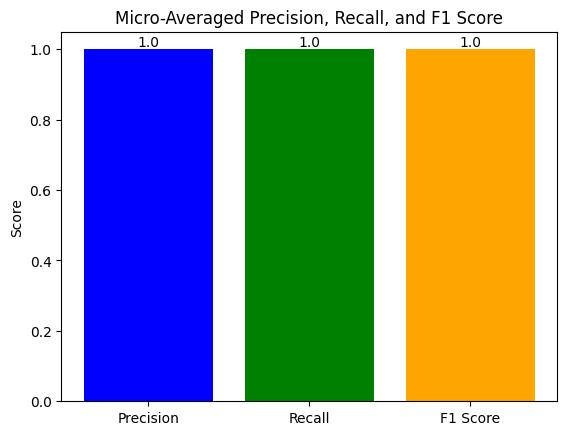

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
# Evaluate precision, recall, and F1-score
predicted_labels = model.predict(test_input)
predicted_labels_binary = (predicted_labels > 0.5).astype(int)

precision = precision_score(test_labels, predicted_labels_binary, average='micro')
recall = recall_score(test_labels, predicted_labels_binary, average='micro')
f1 = f1_score(test_labels, predicted_labels_binary, average='micro')

print(f'Micro-Precision: {precision:.4f}')
print(f'Micro-Recall: {recall:.4f}')
print(f'Micro-F1 Score: {f1:.4f}')

# Plot precision, recall, and F1-score
labels = ['Precision', 'Recall', 'F1 Score']
values = [precision, recall, f1]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['blue', 'green', 'orange'])

# Add value annotations on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.ylabel('Score')
plt.title('Micro-Averaged Precision, Recall, and F1 Score')
plt.show()

In [24]:
# Example usage
new_text = "Apa itu partai politik?"
recommended_keywords = recommend(new_text)
print('Recommended Keywords:')
for keyword in recommended_keywords:
    print(keyword)

1/1 [==============================] - 0s 18ms/step
Recommended Keywords:
('isu', 0.8109305)
('pemerintahan', 0.6845882)
